In [615]:
import pandas as pd
import math
from time import gmtime, strftime
import seaborn as sns
from sklearn.externals import joblib
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
from pprint import pprint
from tqdm import tqdm_notebook
from sklearn import metrics
from sklearn import model_selection
from sklearn import ensemble
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import decomposition
from sklearn import feature_selection
from sklearn import linear_model
from sklearn import feature_selection
from sklearn import cluster
from sklearn import gaussian_process
from sklearn import neighbors
from sklearn import neural_network
from sklearn import isotonic
from sklearn import kernel_ridge
from sklearn import tree
from sklearn import svm
from sklearn import pipeline
from fancyimpute import MICE
from collections import Counter
from scipy import stats
from scipy import optimize
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

#Method new
from sklearn.metrics import r2_score

import warnings

warnings.filterwarnings('ignore')
pd.options.display.max_columns = 400
pd.options.display.max_rows = 100

In [616]:
def output_to_file(id_series, pred_data, with_exp=True):
    if not with_exp:
        pred_data = np.expm1(pred_data)
    final_result = pd.concat([id_series, pd.DataFrame({'SalePrice':pred_data.reshape((-1,))}, index=id_series.index)], axis=1)
    print(final_result)
    final_result.to_csv('prediction_{}.csv'.format(strftime("%Y_%m_%d_%H_%M_%S")), index=False)
    
def save_obj(obj, name):
    try:
        joblib.dump(obj, name)
    except:
        print('Save Failed')

# Data preparation

In [617]:
def pre_data_process(features, labels=None, fn_list=[]):
    new_features = pd.DataFrame(features, copy=True)
    new_labels = None
    if labels is not None:
        new_labels = pd.DataFrame(labels, copy=True)
    
    for fn in fn_list:
        new_features, new_labels = fn(new_features, features, new_labels)
    
    if labels is not None:
        return new_features, new_labels
    
    return new_features

In [618]:
def log1p_labels(features, *args):
    labels = args[1]
    if labels is None:
        return features, None
    return features, np.log1p(labels)

def indicate_cols(features, *args):
    holdout_cols = ['MSSubClass', 'Neighborhood', 'MSZoning']
    for col_name in holdout_cols:
        features[col_name+'_hold'] = pd.Categorical(features[col_name]).codes
        
    return features, args[1]

def fill_na_by_hand(features, *args):
    features.loc[features['MiscFeature'].isnull(),'MiscFeature'] = 'NA'
    features.loc[features['PoolArea']==0,'PoolQC'] = 'NA'
    features.loc[features['Fence'].isnull(),'Fence'] = 'NA'
    features.loc[features['GarageCars']==0, ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']] = 'NA'
    features.loc[features['Fireplaces']==0, 'FireplaceQu'] = 'NA'
    features.loc[features['KitchenAbvGr']==0, 'KitchenQual'] = 'NA'
    features.loc[
        (features.loc[:,['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']]=='NA').sum(axis=1)>0,
        ['BsmtFullBath', 'BsmtHalfBath']
    ] = 0
    features.loc[
        (features.loc[:,['BsmtFinSF1', 'BsmtFinSF2']]==0).sum(axis=1)>0,
        ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
    ] = 'NA'
    features.loc[features['MasVnrType']=='None', 'MasVnrArea'] = 0
    features.loc[features['MasVnrArea']==0, 'MasVnrType'] = 'None'
    features.loc[features['Exterior1st'].isnull(), 'Exterior1st'] = 'Oth'
    features.loc[features['Exterior2nd'].isnull(), 'Exterior2nd'] = 'Oth'
    features.loc[features['Utilities'].isnull(), 'Utilities'] = 'NA'
    features.loc[features['Alley'].isnull(), 'Alley'] = 'NA'
    features.loc[features['Alley']=='NA', 'LotFrontage'] = 0
    return features, args[1]

def add_custom_col(features, *args):
    features['TotalSF'] = features['TotalBsmtSF'] + features['GrLivArea']
    features['HouseStyle_1st'] = 1*(features['HouseStyle'] == '1Story')
    features['HouseStyle_2st'] = 1*(features['HouseStyle'] == '2Story')
    features['HouseStyle_15st'] = 1*(features['HouseStyle'] == '1.5Fin')
    features['HasWoodDeck'] = (features['WoodDeckSF'] == 0) * 1
    features['HasOpenPorch'] = (features['OpenPorchSF'] == 0) * 1
    features['HasEnclosedPorch'] = (features['EnclosedPorch'] == 0) * 1
    features['HasScreenPorch'] = (features['ScreenPorch'] == 0) * 1
    features['BsmtFinType1_Unf'] = 1*(features['BsmtFinType1'] == 'Unf')
    features['YearsSinceRemodel'] = features['YrSold'].astype(int) - features['YearRemodAdd'].astype(int)
    features['Total_Home_Quality'] = features['OverallQual'] + features['OverallCond']
    
    if '3SsnPorch' in features.columns:
        features['Has3SsnPorch'] = (features['3SsnPorch'] == 0) * 1
    else:
        features['Has3SsnPorch'] = (features['X3SsnPorch'] == 0) * 1
    
    return features, args[1]

def fill_na_by_master(features, *args):
    # Master piece by Aleksandrs Gehsbargs
    
    features['Alley'] = features['Alley'].fillna('missing')
    features['PoolQC'] = features['PoolQC'].fillna(features['PoolQC'].mode()[0])
    features['MasVnrType'] = features['MasVnrType'].fillna('None')
    features['BsmtQual'] = features['BsmtQual'].fillna(features['BsmtQual'].mode()[0])
    features['BsmtCond'] = features['BsmtCond'].fillna(features['BsmtCond'].mode()[0])
    features['FireplaceQu'] = features['FireplaceQu'].fillna(features['FireplaceQu'].mode()[0])
    features['GarageType'] = features['GarageType'].fillna('missing')
    features['GarageFinish'] = features['GarageFinish'].fillna(features['GarageFinish'].mode()[0])
    features['GarageQual'] = features['GarageQual'].fillna(features['GarageQual'].mode()[0])
    features['GarageCond'] = features['GarageCond'].fillna('missing')
    features['Fence'] = features['Fence'].fillna('missing')
    features['Street'] = features['Street'].fillna('missing')
    features['LotShape'] = features['LotShape'].fillna('missing')
    features['LandContour'] = features['LandContour'].fillna('missing')
    features['BsmtExposure'] = features['BsmtExposure'].fillna(features['BsmtExposure'].mode()[0])
    features['BsmtFinType1'] = features['BsmtFinType1'].fillna('missing')
    features['BsmtFinType2'] = features['BsmtFinType2'].fillna('missing')
    features['CentralAir'] = features['CentralAir'].fillna('missing')
    features['Electrical'] = features['Electrical'].fillna(features['Electrical'].mode()[0])
    features['MiscFeature'] = features['MiscFeature'].fillna('missing')
    features['MSZoning'] = features['MSZoning'].fillna(features['MSZoning'].mode()[0])    
    features['Utilities'] = features['Utilities'].fillna('missing')
    features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
    features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])    
    features['KitchenQual'] = features['KitchenQual'].fillna(features['KitchenQual'].mode()[0])
    features["Functional"] = features["Functional"].fillna("Typ")
    features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])
    features['SaleCondition'] = features['SaleCondition'].fillna('missing')
    
    flist = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
                     'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',
                     'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
                     'TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF',
                     'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal']
    for fl in flist:
        if fl in features.columns:
            features[fl] = features[fl].fillna(0)
        elif 'X'+fl in features.columns:
            features['X'+fl] = features['X'+fl].fillna(0)
        
    features['TotalBsmtSF'] = features['TotalBsmtSF'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
    features['GarageArea'] = features['GarageArea'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
    features['GarageCars'] = features['GarageCars'].apply(lambda x: 0 if x <= 0.0 else x)
    features['LotFrontage'] = features['LotFrontage'].apply(lambda x: np.exp(4.2) if x <= 0.0 else x)
    features['MasVnrArea'] = features['MasVnrArea'].apply(lambda x: np.exp(4) if x <= 0.0 else x)
    features['BsmtFinSF1'] = features['BsmtFinSF1'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)
    if '2ndFlrSF' in features.columns:
        features['2ndFlrSF'] = features['2ndFlrSF'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)
    else:
        features['X2ndFlrSF'] = features['X2ndFlrSF'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)
    return features, args[1]

def drop_na_features(features, *args):
    drop_col = []
    for col_name in list(features):
        missing_count = features[col_name].isnull().sum()
        percentage = missing_count / len(features[col_name])
        if percentage > 0.35:# or missing_count > 1000:
            drop_col.append(col_name)
        elif percentage > 0:
            if features[col_name].dtypes == np.object:
                features[col_name] = features[col_name].fillna(features[col_name].mode())
                if col_name == 'MasVnrArea':
                    features.loc[features[col_name]=='None', col_name] = 'NA'
            else:
                features[col_name] = features[col_name].fillna(features[col_name].median())
    features.drop(columns=drop_col, inplace=True, errors='ignore')
    return features, args[1]

def fill_numeric(features, *args):
    for col_name in features.select_dtypes(exclude=['object']).columns.tolist():
        features[col_name] = features[col_name].fillna(features[col_name].mean())
    return features, args[1]

def rectify_skewness(features, *args):
    # Boosted by Aleksandrs Gehsbargs
    skew_cols = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
                 'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',
                 'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
                 'TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF',
                 'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','YearRemodAdd','TotalSF']
    
    for col_name in skew_cols:
        if col_name in features.columns:
            features[col_name+'_log'] = np.log1p(features[col_name])
        elif 'X'+col_name in features.columns:
            features[col_name+'_log'] = np.log1p(features['X'+col_name])
    return features, args[1]
    
def custom_drop(features, *args):
    drop_set = {'GarageYrBlt','TotRmsAbvGrd','TotalBsmtSF', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'}
    features.drop(columns=list(drop_set), inplace=True, errors='ignore')
    return features, args[1]

def indicate_quality(features, *args):
    # Boosted by Aleksandrs Gehsbargs
    qualities = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
    mapping = {qual:score for qual, score in zip(qualities, [*range(0, 6)])}
    mapping[np.nan] = 0
    mapping['missing'] = 0
    quality_cols = {'GarageQual', 'GarageCond', 'PoolQC', 'FireplaceQu', 'KitchenQual', 'HeatingQC', 'BsmtQual', 'BsmtCond', 'ExterQual', 'ExterCond'}
    quality_cols = quality_cols & set(features.columns.tolist())
    for col_name in quality_cols:
        features[col_name] = features[col_name].apply(lambda x:mapping[x])
        
    features['CentralAir'] = features['CentralAir'].map({'Y':1, 'N':0})
    features['Street'] = features['Street'].map({'Grvl':0, 'Pave':1})
    features['Utilities'] = features['Utilities'].map({'AllPub':1, 'NoSeWa':0})
    features['BsmtExposure'] = features['BsmtExposure'].map({'Av':2, 'Gd':3, 'Mn':1, 'No':0, np.nan:0})
    features['BsmtFinType1_int'] = features['BsmtFinType1'].map({'ALQ':5, 'BLQ':4, 'GLQ':6, 'LwQ':2, 'Rec':3, 'Unf':1, np.nan:0})
    features['BsmtFinType2'] = features['BsmtFinType2'].map({'ALQ':5, 'BLQ':4, 'GLQ':6, 'LwQ':2, 'Rec':3, 'Unf':1, np.nan:0})
    features['Functional'] = features['Functional'].map({'Maj1':0, 'Maj2':0, 'Min1':1, 'Min2':1, 'Mod':0, 'Sev':0, 'Typ':2})
    features['GarageFinish'] = features['GarageFinish'].map({'Fin':3, 'RFn':2, 'Unf':1, np.nan:0})
    features['PavedDrive'] = features['PavedDrive'].map({'N':0, 'P':0, 'Y':1})
    features['LandSlope'] = features['LandSlope'].map({'Gtl':3, 'Mod':2, 'Sev':1, np.nan:0})
    features['HouseStyle_int'] = features['HouseStyle'].map({'1.5Unf':8, 'SFoyer':7, '1.5Fin':6, '2.5Unf':5, 'SLvl':4, '1Story':3, '2Story':2, '2.5Fin':1, np.nan:0})
    features['Foundation_int'] = features['Foundation'].map({'BrkTil':2, 'CBlock':1, 'PConc':0, 'Slab':3, 'Stone':3, 'Wood':3})
    features['MasVnrType_int'] = features['MasVnrType'].map({'BrkCmn':1, 'BrkFace':2, 'CBlock':0, 'None':0, 'Stone':3})
    
    return features, args[1]

def custom_cat_drop(features, *args):
    categorical_drop = {'Condition2', 'RoofStyle','Electrical', 'Functional'}
    features.drop(columns=categorical_drop, inplace=True, errors='ignore')
    return features, args[1]

def modify_year(features, *args):
    year_cols = {'YearBuilt', 'YearRemodAdd', 'GarageYrBlt'}
    for col_name in year_cols:
        features[col_name] = 2018 - features[col_name]
    return features, args[1]

def add_YrRemodBeforeSold(features, *args):
    ori_features = args[0]
    features['YrRemodBeforeSold'] = ori_features['YrSold'] - ori_features['YearRemodAdd']
    return features, args[1]

def add_Season(features, *args):
    season_dict = {1:1, 2:1, 3:1, 4:0, 5:0, 6:0, 7:3, 8:3, 9:3, 10:2, 11:2, 12:2}
    features['SoldSeason'] = features['MoSold'].map(season_dict)
    return features, args[1]
    
def add_NewerDwelling(features, *args):
    ori_features = args[0]
    features["NewerDwelling"] = ori_features["MSSubClass"].replace(
        {20: 1, 30: 0, 40: 0, 45: 0,50: 0, 60: 1, 70: 0, 75: 0, 80: 0, 85: 0,
         90: 0, 120: 1, 150: 0, 160: 0, 180: 0, 190: 0})
    return features, args[1]

def add_NrhdPriority(features, *args):
    ori_features = args[0]
    neighbor_bin_map = {
        "MeadowV" : 0,  #  88000
        "IDOTRR" : 1,   # 103000
        "BrDale" : 1,   # 106000
        "OldTown" : 1,  # 119000
        "Edwards" : 1,  # 119500
        "BrkSide" : 1,  # 124300
        "Sawyer" : 1,   # 135000
        "Blueste" : 1,  # 137500
        "SWISU" : 2,    # 139500
        "NAmes" : 2,    # 140000
        "NPkVill" : 2,  # 146000
        "Mitchel" : 2,  # 153500
        "SawyerW" : 2,  # 179900
        "Gilbert" : 2,  # 181000
        "NWAmes" : 2,   # 182900
        "Blmngtn" : 2,  # 191000
        "CollgCr" : 2,  # 197200
        "ClearCr" : 3,  # 200250
        "Crawfor" : 3,  # 200624
        "Veenker" : 3,  # 218000
        "Somerst" : 3,  # 225500
        "Timber" : 3,   # 228475
        "StoneBr" : 4,  # 278000
        "NoRidge" : 4,  # 290000
        "NridgHt" : 4,  # 315000
    }
    features['NrhdPriority'] = ori_features['Neighborhood'].map(neighbor_bin_map)
    return features, args[1]

def add_ZonePriority(features, *args):
    zone_map = {
        'C (all)': 0,
        'FV': 4,
        'RH': 2,
        'RL': 3,
        'RM': 1
    }
    ori_features = args[0]
    features['ZonePriority'] = ori_features['MSZoning'].map(zone_map)
    return features, args[1]
    
def dummies(features, *args):
    features['MSSubClass'] = features['MSSubClass'].apply(str)
    features['MoSold'] = features['MoSold'].apply(str)
    cat_cols = set(features.select_dtypes(include=['object']).columns)
    features = pd.get_dummies(features, columns=list(cat_cols))
    features.fillna(0, inplace=True)
    return features, args[1]

def add_squared(features, *args):
    sqpredlist = ['YearRemodAdd', 'LotFrontage_log', 
              'TotalBsmtSF_log', '1stFlrSF_log', '2ndFlrSF_log', 'GrLivArea_log',
              'GarageCars_log', 'GarageArea_log',
              'OverallQual','ExterQual','BsmtQual','GarageQual','FireplaceQu','KitchenQual']
    for col_name in sqpredlist:
        if col_name in features.columns:
            features[col_name + '_sq'] = features[col_name] ** 2
        elif 'X'+col_name in features.columns:
            featurea['X'+col_name+'_sq'] = features['X'+col_name] ** 2
    return features, args[1]

def drop_id(features, *args):
    features = features.drop(columns=["Id"])
    return features, args[1]

def scale(features, *args):
    features = pd.DataFrame(
        columns=features.columns,
        index=features.index,
        data=preprocessing.RobustScaler().fit_transform(features.values)
    )
    return features, args[1]

def denoising(features, *args):
    iso = ensemble.IsolationForest(
        n_estimators=100,
        max_samples=0.9, 
        contamination=contaminate, 
        max_features=0.9, 
        bootstrap=False,
    )
    labels = args[1]
    train_features = features[:len(labels)]
    test_features = features[len(labels):]
    iso.fit(train_features.values)
    group_idx = iso.predict(train_features.values)
    train_features = train_features.iloc[[idx != -1 for idx in group_idx]]
    labels = labels.iloc[[idx != -1 for idx in group_idx[:len(labels)]]]
    features = pd.concat([train_features, test_features])
    return features, labels


def drop_all_categorical(features, *args):
    ori_features = args[0]
    cat_cols = set(ori_features.select_dtypes(include=['object']).columns)
    features.drop(columns=cat_cols, inplace=True, errors='ignore')
    return features, args[1]
    
def MICE_impute(features, *args):
    mice = MICE(visit_sequence='monotone', n_imputations=100, n_burn_in=10, verbose=0)
    numeric_features = features.select_dtypes(exclude=['object'])
    new_features = mice.complete(numeric_features.values)
    new_features = pd.DataFrame(new_features, index=numeric_features.index, columns=numeric_features.columns)
    new_features = pd.concat([new_features, features.select_dtypes(include=['object'])], axis=1)
    return new_features, args[1]
    

## EDA version

In [619]:
def EDA(features, *args):
    ori_features = args[0]
    
    features = ori_features[['LotArea', 'SaleType', 'Functional', 'KitchenQual', 'CentralAir', 'HeatingQC', 'ExterCond', 'ExterQual', 'Exterior2nd', 'Exterior1st', 'HouseStyle', 'BldgType', 'Condition1', 'Neighborhood', 'LandContour', 'MSZoning','ScreenPorch', 'GarageArea', 'Fireplaces', 'KitchenAbvGr', 'FullBath', 'BsmtFullBath', 'BsmtHalfBath', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea']]
    features['LotArea'] = np.log1p(features['LotArea'])
    features['yearRemodAftBld'] = ori_features['YearRemodAdd'] - ori_features['YearBuilt']

    # features['Fireplaces'] = np.log1p(features['Fireplaces'])
    # features['GarageArea'] = np.sqrt(features['GarageArea'])
    # features['LotArea'] = np.log1p(features['LotArea'])

    rule = {1:0, 2:0, 3:1, 4:1, 5:2, 6:1, 7:1, 8:1, 9:1}
    features['OverallCond'] = features['OverallCond'].map(rule)
    features['MSZoning'] = features['MSZoning'].map({'RL':3, 'RM':2, 'RH':1, 'FV':3, 'C (all)':0})
    features['LandContour'] = features['LandContour'].map({'Lvl':0,'Bnk':0, 'Low':0.9, 'HLS':1})

    features['Neighborhood'] = features['Neighborhood'].map({'MeadowV':0, 'IDOTRR':0, 'BrDale':0,'OldTown':1, 'Edwards':1, 'BrkSide':1,'Sawyer':2, 'Blueste':2, 'SWISU':2,'NPkVill':3, 'NAmes':3, 'Mitchel':3,'SawyerW':4, 'Gilbert':4, 'NWAmes':4,'Blmngtn':5, 'CollgCr':5,'ClearCr':6, 'Crawfor':6,'Veenker':7, 'Somerst':7, 'Timber':7,'StoneBr':8, 'NridgHt':8, 'NoRidge':9,})
    features['Condition1'] = features['Condition1'].map({'Artery':0, 'RRAe':0, 'Feedr':0,'RRAn':1, 'Norm':1, 'RRNe':1,'RRNn':1.2, 'PosN':1.2, 'PosA':1.2,})
    features['BldgType'] = features['BldgType'].map({'1Fam':1, 'TwnhsE':1,'Twnhs':0, 'Duplex':0, '2fmCon':0})
    features['HouseStyle'] = features['HouseStyle'].map({'1.5Unf':0, 'SFoyer':1, '1.5Fin':1,'2.5Unf':1, 'SLvl':1, '1Story':1,'2Story':2, '2.5Fin':2})
    features['Exterior1st'] = features['Exterior1st'].map({'VinylSd':3, 'CemntBd':3, 'Stone':2, 'ImStucc':3,'BrkFace':2, 'Plywood':2, 'HdBoard':2, 'Stucco':2, 'WdShing':2, 'Wd Sdng':2, 'MetalSd':2,'AsphShn':1, 'CBlock':1, 'AsbShng':1,'BrkComm':0})
    features['Exterior2nd'] = features['Exterior2nd'].map({'VinylSd':3, 'ImStucc':3, 'CmentBd':3, 'BrkFace':2.5,'Plywood':2, 'HdBoard':2, 'Wd Shng':2, 'Stone':2, 'Stucco':2, 'MetalSd':2, 'Wd Sdng':2,'AsphShn':1, 'Brk Cmn':1, 'AsbShng':1, 'CBlock':1, 'Other':2})

    qual_map = {k:v for v,k in enumerate([np.nan, 'Po','Fa','TA','Gd','Ex'])}

    features['ExterQual'] = features['ExterQual'].map(qual_map)
    features['ExterCond'] = features['ExterCond'].map(qual_map)
    features['HeatingQC'] = features['HeatingQC'].map(qual_map)
    features['CentralAir'] = features['CentralAir'].map({'N':0, 'Y':1})
    features['KitchenQual'] = features['KitchenQual'].map(qual_map)
    features['Functional'] = features['Functional'].map({'Maj2':0, 'Sev':0, 'Min2':1, 'Min1':1, 'Maj1':1, 'Mod':1, 'Typ':1})
    features['SaleType'] = features['SaleType'].map({'New':1, 'Oth':0, 'ConLD':0, 'ConLw':0, 'COD':0, 'WD':0, 'ConLI':0, 'CWD':0, 'Con':0})
    features['BsmtCond'] = ori_features['BsmtCond'].map(qual_map)
    features['MasVnrArea'] = np.log1p(ori_features['MasVnrArea'].fillna(ori_features['MasVnrArea'].mean()))
    features['GarageCond'] = ori_features['GarageCond'].map(qual_map) ** 2
    features['GarageFinish'] = ori_features['GarageFinish'].map({'Unf':1, 'RFn':2, 'Fin':3, np.nan:0})
    features['GarageQual'] = (ori_features['GarageQual'].map(qual_map) * features['GarageCond']) ** (1/2)
    neiFrontMap = dict(ori_features.groupby('Neighborhood').mean()['LotFrontage'])
    features['LotFrontage'] = np.log1p(ori_features['LotFrontage'].fillna(ori_features['Neighborhood'].apply(lambda x:neiFrontMap[x])))
    features['BsmtExposure'] = ori_features['BsmtExposure'].map({'No':0, 'Mn':1, 'Av':2, 'Gd':3, np.nan:3})
    features['BsmtFinType1'] = ori_features['BsmtFinType1'].map({'GLQ':2, 'Unf':2, 'ALQ':1, 'Rec':0, 'BLQ':0, 'LwQ':0, np.nan:2})
    features['BsmtFinType2'] = ori_features['BsmtFinType2'].map({'GLQ':2, 'Unf':2, 'ALQ':1, 'Rec':0, 'BLQ':0, 'LwQ':0, np.nan:2})

    binary_process_rule = {'Functional': [
      {'Typ': 1, 'Min1': 1, 'Maj1': 0, 'Min2': 0, 'Mod': 0, 'Maj2': 0, 'Sev': 0},
      {'Typ': 0, 'Min1': 0, 'Maj1': 0, 'Min2': 0, 'Mod': 1, 'Maj2': 0, 'Sev': 0},
      {'Typ': 0, 'Min1': 0, 'Maj1': 0, 'Min2': 1, 'Mod': 0, 'Maj2': 0, 'Sev': 0},
      {'Typ': 0, 'Min1': 0, 'Maj1': 1, 'Min2': 0, 'Mod': 0, 'Maj2': 0, 'Sev': 0},
      {'Typ': 0, 'Min1': 0, 'Maj1': 0, 'Min2': 0, 'Mod': 0, 'Maj2': 1, 'Sev': 1}],
     'OverallCond': [{5: 0, 8: 0, 6: 0, 7: 0, 4: 0, 2: 0, 3: 1, 9: 0, 1: 0},
      {5: 1, 8: 0, 6: 0, 7: 0, 4: 1, 2: 0, 3: 0, 9: 0, 1: 0},
      {5: 0, 8: 0, 6: 1, 7: 0, 4: 0, 2: 1, 3: 0, 9: 0, 1: 1},
      {5: 0, 8: 1, 6: 0, 7: 0, 4: 0, 2: 0, 3: 0, 9: 0, 1: 0},
      {5: 0, 8: 0, 6: 0, 7: 1, 4: 0, 2: 0, 3: 0, 9: 0, 1: 0},
      {5: 0, 8: 0, 6: 0, 7: 0, 4: 0, 2: 0, 3: 0, 9: 1, 1: 0}],
     'GarageCond': [{'TA': 0, 'Fa': 0, np.nan: 0, 'Gd': 1, 'Po': 0, 'Ex': 0}]}
    for k, v in binary_process_rule.items():
        for i, rule in enumerate(v):
            rule[np.nan] = 0
            features[k+'_bin_'+str(i)] = ori_features[k].map(rule)

    features['Functional_sq'] = features['Functional'] ** 2
    features['OverallCond_root'] = features['OverallCond'] ** (1/2)


    dummy_cols = ['LandContour', 'Neighborhood', 'HouseStyle', 'Exterior1st', 'ExterQual', 'KitchenQual', 'SaleType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType2']
    dummy_src = ori_features[dummy_cols]
    features = pd.concat([features, pd.get_dummies(dummy_src, columns=dummy_cols)], axis=1)

    features['Functional_Exterior1st'] = features['Functional'] * features['Exterior1st']
    features['Functional_MSZoning'] = features['Functional'] * features['MSZoning']
    
    return features, args[1]


# Metrics

In [620]:
def rmse(y, y_pred):
    return np.sqrt(metrics.mean_squared_error(y, y_pred))

RMSE = metrics.make_scorer(rmse, greater_is_better=False)

def ad_r2(y, y_pred, n_features):
    if isinstance(y, (pd.DataFrame, pd.Series)):
        y = y.values
        
    r2 = metrics.r2_score(y, y_pred)
    n_observe = y.shape[0]
    return 1 - (1 - r2) * (n_observe - 1) / (n_observe - n_features - 1)

def add_r2_cv(model, features, labels):
    if isinstance(features, (pd.DataFrame, pd.Series)):
        features = features.values
    if isinstance(labels, (pd.DataFrame, pd.Series)):
        labels = labels.values
        
    r2 = model_selection.cross_val_score(model, features, labels, scoring=R2)
    n_observe = features.shape[0]
    n_features = features.shape[1]
    return 1 - (1 - r2) * (n_observe - 1) / (n_observe - n_features - 1)
    
R2 = metrics.make_scorer(metrics.r2_score, greater_is_better=True)

# Tools

In [621]:
def plot_learning_curve_self_implement(estimator, x, y, title='Baseline', ylim=None, cv=5,
                        train_sizes=np.linspace(.1, 1.0, 5), shuffle=False, holdout=0.1, exploit_incremental_learning=False):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    if isinstance(x, (pd.DataFrame,pd.Series)):
        x = x.values
    if isinstance(y, (pd.DataFrame,pd.Series)):
        y = y.values
    
    x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=holdout)
    kfold = model_selection.KFold(n_splits=cv, shuffle=True)
    
    train_scores = []
    val_scores = []
    test_scores = []
    
    train_sizes = np.array(train_sizes)
    train_sizes = np.multiply(train_sizes, len(x_train)).astype(int)
    
    for size in train_sizes:
        x_train_sample = x_train[:size,:]
        y_train_sample = y_train[:size]
        print(size, x_train_sample.shape)
        
        train_scores_curfold = []
        val_scores_curfold = []
        test_scores_curfold = []
        
        for train_idx, val_idx in kfold.split(x_train_sample, y_train_sample):
            cur_x_train = x_train_sample[train_idx]
            cur_y_train = y_train_sample[train_idx]
            cur_x_val = x_train_sample[val_idx]
            cur_y_val = y_train_sample[val_idx]
            
            estimator.fit(cur_x_train, cur_y_train)
            train_scores_curfold.append(rmse(cur_y_train, estimator.predict(cur_x_train)))
            val_scores_curfold.append(rmse(cur_y_val, estimator.predict(cur_x_val)))
            test_scores_curfold.append(rmse(y_test, estimator.predict(x_test)))
            
        train_scores.append(train_scores_curfold[:])
        val_scores.append(val_scores_curfold[:])
        test_scores.append(test_scores_curfold[:])
        
    train_scores = np.array(train_scores)
    val_scores = np.array(val_scores)
    test_scores = np.array(test_scores)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()
    plt.figure(figsize=(12,12))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                     val_scores_mean + val_scores_std, alpha=0.1, color="g")
    
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="b")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    
    plt.plot(train_sizes, val_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    
    plt.plot(train_sizes, test_scores_mean, 'o-', color="b",
             label="Test score")
    
    for i, size in enumerate(train_sizes):
        plt.text(size, train_scores_mean[i]-0.01, "{:.3f}".format(train_scores_mean[i]))
        plt.text(size, val_scores_mean[i]+0.01, "{:.3f}".format(val_scores_mean[i]))
        plt.text(size, test_scores_mean[i]+0.01, "{:.3f}".format(test_scores_mean[i]))
    
#     plt.legend(loc="best")
    return plt

def plot_learning_curve(estimator, x, y, title='Baseline', ylim=None, cv=5,
                        train_sizes=np.linspace(.1, 1.0, 5), shuffle=False, exploit_incremental_learning=False):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = model_selection.learning_curve(
        estimator, x, y, cv=cv, n_jobs=-1, train_sizes=train_sizes, 
        scoring=RMSE, shuffle=shuffle, exploit_incremental_learning=exploit_incremental_learning)

    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    for i, size in enumerate(train_sizes):
        plt.text(size, train_scores_mean[i]-0.01, "{:.3f}".format(train_scores_mean[i]))
        plt.text(size, test_scores_mean[i]+0.01, "{:.3f}".format(test_scores_mean[i]))
    
#     plt.legend(loc="best")
    return plt

def plot_validation_curve(estimator, x, y, param_name, param_range, title='Baseline', holdout=0.0, ylim=None, cv=None):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("{} range".format(param_name))
    plt.ylabel("Score")
    
    train_scores, test_scores = model_selection.validation_curve(
        estimator, x, y, param_name, param_range, cv=cv, scoring=RMSE, n_jobs=-1)

    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(param_range, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(param_range, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    for i, param in enumerate(param_range):
        plt.text(param, train_scores_mean[i]-0.003, "{:.3f}".format(train_scores_mean[i]))
        plt.text(param, test_scores_mean[i]+0.003, "{:.3f}".format(test_scores_mean[i]))
    
#     plt.legend(loc="best")
    print('{}')
    return plt
    
def plot_cv_pred(estimator, x, y, title='Baseline', cv=None, offset_up=None, offset_down=None):
    predicted = model_selection.cross_val_predict(estimator, x, y, cv=cv, n_jobs=-1)

    fig, ax = plt.subplots(figsize=(12,12))
    ax.set_title(title)
    ax.scatter(y, predicted, edgecolors=(0, 0, 0))
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
    
    if isinstance(offset_up, (int, float)):
        ax.plot([y.min(), y.max()], [y.min()+offset_up, y.max()+offset_up])
    if isinstance(offset_down, (int, float)):
        ax.plot([y.min(), y.max()], [y.min()-offset_down, y.max()-offset_down])

    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    plt.show()
    return predicted
    
def plot_pred(y, y_pred, title='y - y_pred', reverse=False, offset_up=None, offset_down=None):
    fig, ax = plt.subplots(figsize=(12,12))
    ax.set_title(title)
    if reverse:
        ax.scatter(y_pred, y, edgecolors=(0, 0, 0))
        ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
        if isinstance(offset_up, (int, float)):
            ax.plot([y.min(), y.max()], [y.min()+offset_up, y.max()+offset_up])
        if isinstance(offset_down, (int, float)):
            ax.plot([y.min(), y.max()], [y.min()-offset_down, y.max()-offset_down])
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Measured')
    else:
        ax.scatter(y, y_pred, edgecolors=(0, 0, 0))
        ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
        if isinstance(offset_up, (int, float)):
            ax.plot([y.min(), y.max()], [y.min()+offset_up, y.max()+offset_up])
        if isinstance(offset_down, (int, float)):
            ax.plot([y.min(), y.max()], [y.min()-offset_down, y.max()-offset_down])
        ax.set_xlabel('Measured')
        ax.set_ylabel('Predicted')
    plt.show()
    return ax
     
def compare_framework(f1, f2, x_train, y_train, x_test, y_test, cv_range=[2,3,4,5,6], repeat=10, title='Framework Compare'):
    ridge = linear_model.Ridge(tol=0.001,normalize=False,max_iter=10000,fit_intercept=True,alpha=20.0)
    lgbm = LGBMRegressor(boosting_type='gbdt',num_leaves=31,max_depth=8,learning_rate=0.1,n_estimators=200,  min_split_gain=0.01, min_child_weight=0.001, min_child_samples=4, subsample=1.0, subsample_freq=0, colsample_bytree=0.3,reg_alpha=0.3, reg_lambda=0.1, n_jobs=1)
    xgb = XGBRegressor(max_depth=7, learning_rate=0.13,n_estimators=120, objective='reg:linear', booster='gbtree',  gamma=0.5,min_child_weight=3, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=0.4, reg_alpha=3,reg_lambda=1, scale_pos_weight=2.0, base_score=0.5)
    gbrt = ensemble.GradientBoostingRegressor(loss='ls',learning_rate=0.1,n_estimators=250,subsample=1,criterion='friedman_mse', min_samples_split=40,min_samples_leaf=6, max_depth=3, min_impurity_decrease=0.008, max_features=0.4, alpha=0.99,max_leaf_nodes=None)
    lasso = linear_model.Lasso(alpha=0.0, positive=True)
    times = [4,4,4,4]
    models_1 = [ridge, lgbm, xgb, gbrt]
    
    f1_pred_mean = []
    f1_pred_std = []
    f2_pred_mean = []
    f2_pred_std = []
    
    for cv in tqdm_notebook(cv_range):
        f1_pred_per_cv = []
        f2_pred_per_cv = []
        
        for _ in range(repeat):
            f1_pred = f1(models_1, times, lasso, x_train, y_train, x_test, cv=cv, save=False).reshape((-1,))
            f2_pred = f2(models_1, times, lasso, x_train, y_train, x_test, cv=cv, save=False).reshape((-1,))
            
            f1_score = rmse(y_test, f1_pred)
            f2_score = rmse(y_test, f2_pred)
            
            f1_pred_per_cv.append(f1_score)
            f2_pred_per_cv.append(f2_score)
        
        f1_pred_per_cv = np.array(f1_pred_per_cv)
        f2_pred_per_cv = np.array(f2_pred_per_cv)
            
        f1_pred_mean.append(np.mean(f1_pred_per_cv))
        f2_pred_mean.append(np.mean(f2_pred_per_cv))
        f1_pred_std.append(np.std(f1_pred_per_cv))
        f2_pred_std.append(np.std(f2_pred_per_cv))
        
    f1_pred_mean = np.array(f1_pred_mean)
    f1_pred_std = np.array(f1_pred_std)
    f2_pred_mean = np.array(f2_pred_mean)
    f2_pred_std = np.array(f2_pred_std)
    
    plt.grid()
    
    plt.fill_between(cv_range, f1_pred_mean - f1_pred_std,
                     f1_pred_mean + f1_pred_std, alpha=0.1,
                     color="r")
    plt.fill_between(cv_range, f2_pred_mean - f2_pred_std,
                     f2_pred_mean + f2_pred_std, alpha=0.1, color="g")
    plt.plot(cv_range, f1_pred_mean, 'o-', color="r",
             label="f1 score")
    plt.plot(cv_range, f2_pred_mean, 'o-', color="g",
             label="f2 score")
    
    plt.legend(loc="best")
    return plt
    
def eval_dataset(x, y):
    if isinstance(x, (pd.DataFrame, pd.Series)):
        x = x.values
    if isinstance(y, (pd.DataFrame, pd.Series)):
        y = y.values
        
    ridge = linear_model.Ridge(tol=0.001,normalize=False,max_iter=10000,fit_intercept=True,alpha=40.0)
    gbrt = ensemble.GradientBoostingRegressor(loss='ls',learning_rate=0.1,n_estimators=200,subsample=1,criterion='friedman_mse', min_samples_split=40,min_samples_leaf=3, max_depth=3, min_impurity_decrease=0, max_features=0.2, alpha=0.7,max_leaf_nodes=None)

    ridge_cv_r2 = np.mean(add_r2_cv(ridge, x, y))
    ridge_cv_rmse = -np.mean(model_selection.cross_val_score(ridge, x, y, scoring=RMSE))
    gbrt_cv_r2 = np.mean(add_r2_cv(gbrt, x, y))
    gbrt_cv_rmse = -np.mean(model_selection.cross_val_score(gbrt, x, y, scoring=RMSE))
    print('Ridge: r2->{}\t rmse->{}'.format(ridge_cv_r2, ridge_cv_rmse))
    print('gbrt: r2->{}\t rmse->{}'.format(gbrt_cv_r2, gbrt_cv_rmse))
    
    return ridge_cv_r2, ridge_cv_rmse, gbrt_cv_r2, gbrt_cv_rmse

## Deprecated

In [623]:
def likelihood_encode(x_train, y, x_test, col_list=[], target_col='SalePrice', on=True):
    if not on:
        return x_train, y, x_test
    
    data = pd.concat([x_train, y], axis=1)
    x_train_new = x_train.copy()
    x_test_new = x_test.copy()
    for col_name in col_list:
        rule = dict(data.groupby(col_name+'_hold').mean()[target_col])
        y_mean = y.values.mean()
        process = lambda x: rule.get(x, y_mean)
        
        x_train_new[col_name+'_hold'] = x_train_new[col_name+'_hold'].apply(process)
        x_test_new[col_name+'_hold'] = x_test_new[col_name+'_hold'].apply(process)
    return x_train_new, y, x_test_new

In [624]:
def train(model, features_train, labels, features_test, times, likelihood=True, cv=5):
    n = len(labels)
    y_test_pred = []
    train_oof_pred = []

    _, _, x_test = likelihood_encode(
        features_train,
        labels,
        features_test,
        col_list=['MSSubClass', 'Neighborhood', 'MSZoning'],
        on=likelihood
    )

    for t in tqdm_notebook(range(times)):
        kfold = model_selection.KFold(n_splits=cv, shuffle=True, random_state=None)
        oof = np.zeros_like(labels.values)
        cur_fold_test_pred = []
        fold_test_pred = np.ones((x_test.shape[0],1))
        for train_idx, val_idx in kfold.split(features_train, labels):
            x_train, y, x_val = likelihood_encode(
                features_train.iloc[train_idx],
                labels.iloc[train_idx],
                features_train.iloc[val_idx],
                col_list=['MSSubClass', 'Neighborhood', 'MSZoning'],
                on=likelihood
            )
            
            model.fit(x_train.values, y.values)
            oof[val_idx] = model.predict(x_val.values).reshape((-1,1))
            fold_test_pred = fold_test_pred * model.predict(x_test.values).reshape((-1,1))
        
        train_oof_pred.append(oof.reshape((-1,1)))
        y_test_pred.append((fold_test_pred ** (1/cv)).reshape((-1,1)))
        
    train_oof_pred = np.concatenate(train_oof_pred, axis=1)
    y_test_pred = np.concatenate(y_test_pred, axis=1)
    return train_oof_pred, y_test_pred

def trust_the_process_1(models_1, times, model_2, features_train, labels, features_test, cv=5, save=False, likelihood=False, verbose=0):
    oof_pred_each_model = []
    test_pred_each_model = []
    for time, model in zip(times, models_1):
        if verbose > 0:
            print('Working on model {}'.format(model.__class__.__name__))
        oof_pred, test_pred = train(model, features_train, labels, features_test, time, cv=cv, likelihood=likelihood)
        oof_pred_each_model.append(oof_pred)
        test_pred_each_model.append(test_pred)
        
    oof_features = np.concatenate(oof_pred_each_model, axis=1)
    test_features = np.concatenate(test_pred_each_model, axis=1)

    model_2.fit(oof_features, labels)
    
    if verbose > 0:
        print(model_2.coef_)
    
    final_pred = model_2.predict(test_features)
    
    if save:
        save_obj(oof_features, 'oof_features')
        save_obj(test_features, 'test_features')
        output_to_file(raw_test_data['Id'], final_pred)
    return final_pred

In [625]:
def trust_the_process_2(models_1, times, model_2, features_train, labels, features_test, cv=5, save=False):
    x_train = features_train.values
    y = labels.values
    x_test = features_test.values
    
    kfold = model_selection.KFold(n_splits=cv, shuffle=True, random_state=None)
    final_pred = np.ones((len(features_test), 1))
    
    for train_idx, val_idx in kfold.split(x_train, y):
        for model in models_1:
            model.fit(x_train[train_idx], y[train_idx])
            
        oof_pred_each_model = [model.predict(x_train[val_idx]).reshape((-1,1)) for model in models_1]
        mix_pred = np.ones_like(y[val_idx]).reshape((-1,1))
        for pred in oof_pred_each_model:
            mix_pred = mix_pred * pred
        mix_pred = mix_pred ** (1 / len(oof_pred_each_model))
        
        oof_pred_each_model.append(mix_pred)
        oof_pred_cur_fold = np.concatenate(oof_pred_each_model, axis=1)

        model_2.fit(oof_pred_cur_fold, y[val_idx])
        
        test_pred_each_model = [model.predict(x_test).reshape((-1,1)) for model in models_1]
        test_mix_pred = np.ones_like(test_pred_each_model[0])
        for pred in test_pred_each_model:
            test_mix_pred = test_mix_pred * pred
        test_mix_pred = test_mix_pred ** (1 / len(test_pred_each_model))
        
        test_pred_each_model.append(test_mix_pred)
        test_pred_each_model = np.concatenate(test_pred_each_model, axis=1)
        
        final_pred = final_pred * model_2.predict(test_pred_each_model).reshape((-1,1))
        
    final_pred = final_pred ** (1 / cv)
    
    
    if save:
        output_to_file(raw_test_data['Id'], final_pred)
        
    return final_pred

# Data source

### Data from R

In [626]:
rtrain_data_url = 'rtrain.csv'
rtest_data_url = 'rtest.csv'
r_train_data = pd.read_csv(rtrain_data_url)
r_test_data = pd.read_csv(rtest_data_url)
r_all_features = pd.concat([r_train_data.drop(columns=["SalePrice"]), r_test_data], axis=0)

fn_list_r = [
    fill_na_by_master,
    add_custom_col,
    log1p_labels, 
    indicate_quality, 
    rectify_skewness,
    add_squared,
    add_NewerDwelling, 
    add_NrhdPriority,
    add_ZonePriority,
    dummies, 
    drop_all_categorical,
    denoising
]

if 'Unnamed: 0' in r_all_features.columns:
    r_all_features.drop(columns=['Unnamed: 0'], inplace=True)
rfeatures, rlabels = pre_data_process(r_all_features, r_train_data['SalePrice'], fn_list_r)
x_rtrain = rfeatures[:len(rlabels)].values
x_rtest = rfeatures[len(rlabels):].values
y_r = rlabels.values


### Data from py

In [660]:
train_data_url = 'train.csv'
test_data_url = 'test.csv'

raw_train_data = pd.read_csv(train_data_url)
outlier_idx = raw_train_data[(raw_train_data['SalePrice'] < 3e5) & (raw_train_data['GrLivArea'] > 4e3)].index
raw_train_data.drop(outlier_idx, inplace=True)
raw_test_data = pd.read_csv(test_data_url)
all_features = pd.concat([raw_train_data.drop(columns=["SalePrice"]), raw_test_data], axis=0)

contaminate = 0.01

fn_list_1 = [
    #MICE_impute,
    log1p_labels,
    #EDA,
    fill_na_by_master,
    #fill_na_by_hand,
    indicate_quality, 
    drop_na_features,
    fill_numeric,
    #indicate_cols,
    add_custom_col, 
    drop_id,
    rectify_skewness, 
    add_squared,
    add_NewerDwelling, 
    add_NrhdPriority,
    add_ZonePriority,
    dummies,
    drop_all_categorical, 
    denoising,
    #scale,
]

features_1, labels_1 = pre_data_process(raw_train_data.drop('SalePrice', axis=1), raw_train_data['SalePrice'], fn_list_1)
x_train_1 = features_1
x_test_1 = pre_data_process(raw_test_data, fn_list=fn_list_1)
x_test_1.drop(list(set(x_test_1.columns) - set(x_train_1.columns)), axis=1, inplace=True)
y_1 = labels_1
x_train_1.drop(columns=list(set(x_train_1.columns) - set(x_test_1.columns)), inplace=True)
print(x_train_1.shape, x_test_1.shape, y_1.shape)

fn_list_2 = [
    #MICE_impute,
    log1p_labels,
    EDA,
    #fill_na_by_master,
    #fill_na_by_hand,
    #indicate_quality, 
    #drop_na_features,
    fill_numeric,
    #indicate_cols,
    #add_custom_col, 
    #drop_id,
    #rectify_skewness, 
    #add_squared,
    #add_NewerDwelling, 
    #add_NrhdPriority,
    #add_ZonePriority,
    #dummies,
    #drop_all_categorical, 
    #denoising,
    #scale,
]

features_2, labels_2 = pre_data_process(raw_train_data.drop('SalePrice', axis=1), raw_train_data['SalePrice'], fn_list_2)
x_train_2 = features_2
x_test_2 = pre_data_process(raw_test_data, fn_list=fn_list_2)
y_2 = labels_2
x_train_2.drop(columns=list(set(x_train_2.columns) - set(x_test_2.columns)), inplace=True)

print(x_train_2.shape, x_test_2.shape, y_2.shape)



(1458, 290) (1459, 290) (1458, 1)
(1458, 139) (1459, 139) (1458, 1)


# Dirty trial

{}
{}


<module 'matplotlib.pyplot' from '/Users/pd/miniconda3/envs/dpl/lib/python3.6/site-packages/matplotlib/pyplot.py'>

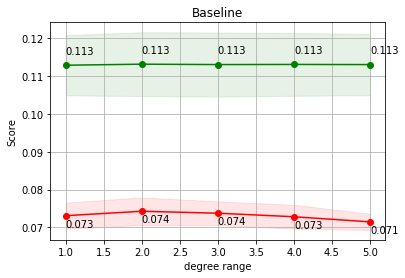

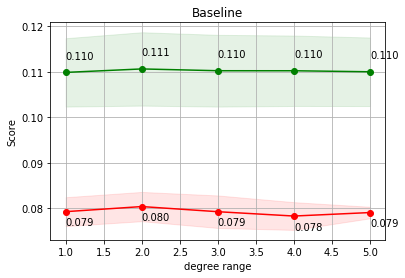

In [663]:
plot_validation_curve(sr, x_train_1, y_1, 'degree', [1,2,3,4,5])
plot_validation_curve(sr, x_train_2, y_2, 'degree', [1,2,3,4,5])

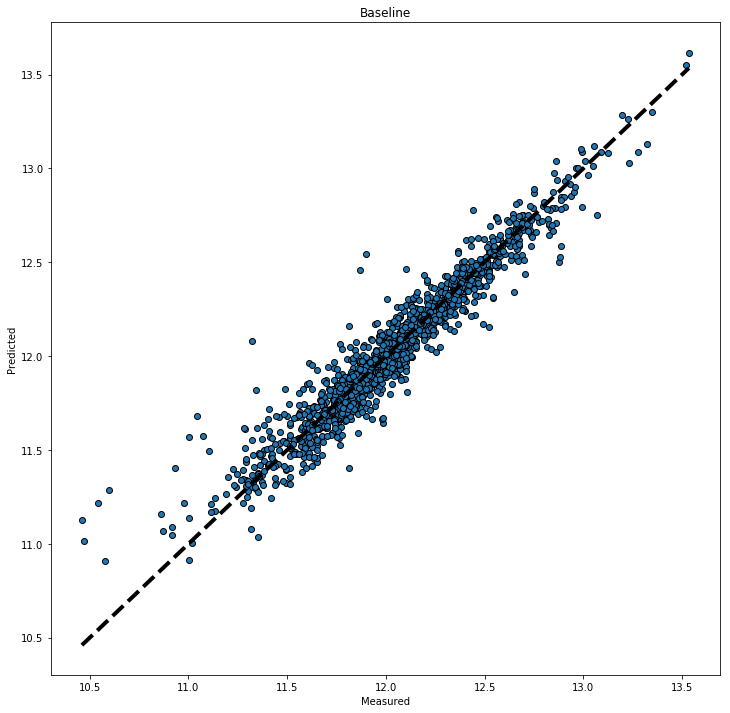

<module 'matplotlib.pyplot' from '/Users/pd/miniconda3/envs/dpl/lib/python3.6/site-packages/matplotlib/pyplot.py'>

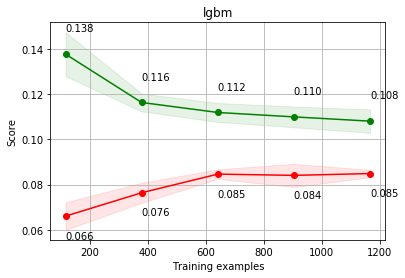

In [533]:
models_1 = [ridge, enet, lasso, lgbm, gbrt]
model_2 = linear_model.Lasso(alpha=0.001, positive=False)
sr = StackRegressor(models_1, model_2, cv=5, verbose=0, shuffle=True)

# plot_validation_curve(sr, x_train, y, 'positive', [True, False])
plot_learning_curve(sr, x_train, y, 'lgbm')

# Framework

Feature sample inside

In [664]:
def gen_model(name):
    if name == 'ridge':
        ridge = linear_model.Ridge(
            tol=0.001,
            normalize=False,
            max_iter=10000,
            fit_intercept=True,
            alpha=7.0
        )
        return ridge

    if name == 'lasso':
        lasso = linear_model.Lasso(
            tol=0.001,
            normalize=False,
            max_iter=10000,
            fit_intercept=True,
            alpha=0.0003
        )
        return lasso

    if name == 'enet':
        enet = linear_model.ElasticNet(
            alpha=0.001,
            l1_ratio=0.325,
            fit_intercept=True,
            normalize=False,
            precompute=False, 
            max_iter=10000
        )
        return enet

    if name == 'lgbm':
        lgbm = LGBMRegressor(
            boosting_type='gbdt',
            num_leaves=31,
            max_depth=5,
            learning_rate=0.05,
            n_estimators=500,  
            min_split_gain=0, 
            min_child_weight=0.001, 
            min_child_samples=4, 
            subsample=1.0, 
            subsample_freq=0, 
            colsample_bytree=0.422,
            reg_alpha=0.15, 
            reg_lambda=0.08, 
            n_jobs=1,
        )
        return lgbm

    if name == 'xgb':
        xgb = XGBRegressor(
            max_depth=5, 
            learning_rate=0.1,
            n_estimators=500, 
            objective='reg:linear', 
            booster='gbtree',  
            gamma=0.05,
            min_child_weight=3, 
            max_delta_step=0, 
            subsample=1, 
            colsample_bytree=1, 
            colsample_bylevel=0.225, 
            reg_alpha=10,
            reg_lambda=2.5, 
            scale_pos_weight=2.0, 
            base_score=0.5, 
        )
        return xgb

    if name == 'gbrt':
        gbrt = ensemble.GradientBoostingRegressor(
            loss='ls',
            learning_rate=0.07,
            n_estimators=500,
            subsample=1,
            criterion='friedman_mse', 
            min_samples_split=2,
            min_samples_leaf=3, 
            max_depth=3, 
            min_impurity_decrease=0.00105, 
            max_features=0.2, 
            alpha=0.2,
            max_leaf_nodes=None,
        )
        return gbrt

    if name == 'rf':
        rf = ensemble.RandomForestRegressor(
            n_estimators=80,
            criterion='mse',
            max_depth=None,
            min_samples_split=2, 
            min_samples_leaf=1, 
            max_features=0.2,
            max_leaf_nodes=None, 
            min_impurity_decrease=0,
            bootstrap=True, 
        )
        return rf

In [604]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.base import clone

class StackRegressor(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models_1, model_2, cv=5, degree=1, verbose=0, shuffle=True, random_state=None):
        self.models_1 = models_1
        self.model_2 = model_2
        self.model_stack = []
        self.cv = cv
        self.shuffle = shuffle
        self.random_state = random_state
        self.verbose = verbose
        self.degree = 1
        
    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        if isinstance(X, (pd.DataFrame)):
            self.X_ = X.values
        else:
            self.X_ = X
        
        if isinstance(y, (pd.DataFrame, pd.Series)):
            self.y_ = y.values
        else:
            self.y_ = y
        
        self.model_2 = pipeline.make_pipeline(preprocessing.PolynomialFeatures(self.degree), self.model_2)
        kfold = model_selection.KFold(n_splits=self.cv, shuffle=self.shuffle, random_state=self.random_state)
        self.model_stack = []
        
        oof = np.zeros((self.y_.shape[0], len(self.models_1)))
        for train_idx, val_idx in kfold.split(self.X_, self.y_):
            X_train = self.X_[train_idx]
            y_train = self.y_[train_idx]
            X_val = self.X_[val_idx]
            y_val = self.y_[val_idx]
            
            cur_fold_stack = []
            
            for i, model in enumerate(self.models_1):
                cur_fold_stack.append(clone(model))
                cur_fold_stack[-1].fit(X_train, y_train)
                oof[val_idx.tolist(), i] = cur_fold_stack[-1].predict(X_val)
            
            self.model_stack.append(cur_fold_stack)

        self.model_2.fit(oof, self.y_)

        return self

    def predict(self, X):
        assert len(self.model_stack) > 0, 'You should fit model first before predicting'
        check_is_fitted(self, ['X_', 'y_'])
        
        if isinstance(X, (pd.DataFrame)):
            X = X.values
        
        # Input validation
        X = check_array(X)
        pred = np.ones((X.shape[0], len(self.models_1)))
        for stack in self.model_stack:
            
            layer1_output = []
            for model in stack:
                model.predict(X).reshape((-1,1))
                layer1_output.append(model.predict(X).reshape((-1,1)))
                
            layer1_output = np.concatenate(layer1_output, axis=1)
            pred *= layer1_output
            
        pred = pred ** (1 / len(self.model_stack))
        return self.model_2.predict(pred)
    
    def transform(self, X):
        return self.predict(X).reshape((-1, 1))
    
    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X)
    
    def get_params(self, deep=True):
        return {
            "models_1": self.models_1,
            "model_2": self.model_2,
            "cv": self.cv,
            "shuffle": self.shuffle,
            "random_state": self.random_state,
            "verbose": self.verbose,
            "degree": self.degree
        }

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)

        return self

# Final Test

After test, it turns out:
1. Likelihood encoding is not helping in this case
2. In stacking models, the second layer model will be better if we only create one such model and fit it the whole OOF prediction, better than the case that we create a sencond layer model for each cv fold and make a prediction, and output the average of those predictions.

In [666]:
models_1 = [gen_model('ridge') for _ in range(10)] + [gen_model('lasso') for _ in range(10)]
models_1 += [gen_model('enet') for _ in range(20)] + [gen_model('xgb') for _ in range(5)]
models_1 += [gen_model('lgbm') for _ in range(10)] + [gen_model('gbrt') for _ in range(10)]

model_2 = LGBMRegressor(
            boosting_type='gbdt',
            num_leaves=31,
            max_depth=5,
            learning_rate=0.05,
            n_estimators=500,  
            min_split_gain=0, 
            min_child_weight=0.001, 
            min_child_samples=4, 
            subsample=1.0, 
            subsample_freq=0, 
            colsample_bytree=0.422,
            reg_alpha=0.15, 
            reg_lambda=0.08, 
            n_jobs=1,
        )
sr = StackRegressor(models_1, model_2, cv=5, degree=4, verbose=0, shuffle=True)

sr.fit(x_train_1, y_1)
final_pred = sr.predict(x_test_1)

# rtest_pred_url = 'svm_solution_32.csv'
# rtest_pred = np.log1p(pd.read_csv(rtest_pred_url)['SalePrice'].values.reshape((-1,)))
# final_pred = (final_pred.reshape((-1,)) * rtest_pred) ** (1/2)




In [668]:
# final_pred_cut = linear_modify_result(final_pred, 0.0072, 0.984, 0.9647, 1.0040)
output_to_file(raw_test_data['Id'], final_pred, with_exp=False)


        Id      SalePrice
0     1461  115978.587248
1     1462  162801.925873
2     1463  178631.123800
3     1464  195561.252166
4     1465  181840.496092
5     1466  174749.628658
6     1467  176730.883571
7     1468  168053.190309
8     1469  175731.999630
9     1470  117596.587404
10    1471  190504.746270
11    1472   89090.967407
12    1473   96880.237178
13    1474  151163.302852
14    1475  117866.653737
15    1476  385761.828172
16    1477  243046.095482
17    1478  277030.568456
18    1479  290251.706803
19    1480  543856.722786
20    1481  320325.751899
21    1482  198954.170755
22    1483  174818.629906
23    1484  164685.249127
24    1485  185224.066927
25    1486  192319.093800
26    1487  312746.608374
27    1488  226445.443447
28    1489  205272.650051
29    1490  221451.547241
30    1491  185212.832429
31    1492   94964.511566
32    1493  171541.086275
33    1494  314815.717950
34    1495  309820.310103
35    1496  239789.739232
36    1497  161395.564323
37    1498  

# Ensemble Output

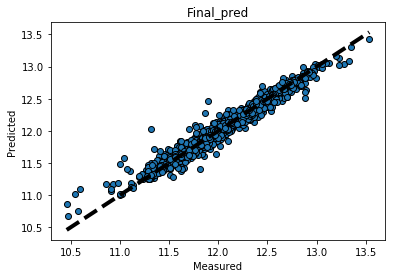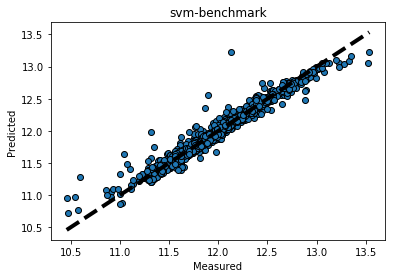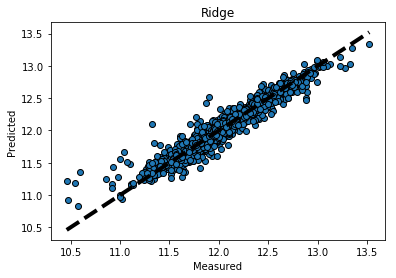

In [137]:
svm_output = pd.read_csv('svm_solution_32.csv')
svm_output.drop('Id', axis=1, inplace=True)

pred_output = pd.read_csv('prediction_2018_07_24_01_06_28.csv')
pred_output.drop('Id', axis=1, inplace=True)

In [138]:
fin_data = (pred_output * svm_output) ** (1/2)

q1 = fin_data['SalePrice'].quantile(0.01)
q2 = fin_data['SalePrice'].quantile(0.99)
print(np.log1p(q1), np.log1p(q2))
fin_data['SalePrice'] = fin_data['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
fin_data['SalePrice'] = fin_data['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)

# fin_data

11.054275587242822 12.980826438488517


In [1435]:
output_to_file(raw_test_data['Id'], fin_data, with_exp=True)

        Id      SalePrice
0     1461  120387.169859
1     1462  168419.414083
2     1463  185609.868549
3     1464  201222.349714
4     1465  190950.319817
...    ...            ...
1454  2915   88831.439533
1455  2916   80244.202650
1456  2917  170800.282319
1457  2918  115716.457514
1458  2919  217979.437203

[1459 rows x 2 columns]
